In [1]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
import cv2
from collections import defaultdict 
# import imagehash
# from PIL import Image

In [2]:
# import some data generated by nightshade
load_dotenv()

ok_pic_formats = {"jpg", "jpeg", "webp", "png"}

nightshade_pic_location = os.getenv("NIGHTSHADE_PIC_LOCATION")
regular_pic_location = os.getenv("REGULAR_PIC_LOCATION")



### OpenCV - iamge resizing

In [3]:
# Basic Image Perturbation
def import_image(input_path):
    image = cv2.imread(input_path)
    if image is None:
        print("Error: Image not found.")
        return
    else:
        return image

def resize_image(image, new_width, new_height):
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)


def pad_image(image, new_width, new_height, pad_value=(0, 0, 0), borderType=cv2.BORDER_CONSTANT):
    """
    Pads an image to a specified width and height with a constant border value.

    Args:
        image: The image to be padded (numpy array).
        new_width: The desired width of the padded image.
        new_height: The desired height of the padded image.
        pad_value: The value to fill the padded area (tuple of 3 integers for BGR). Defaults to black (0, 0, 0).
        borderType: OpenCV border type for padding. Defaults to cv2.BORDER_CONSTANT.

    Returns:
        A padded image (numpy array).
    """

    height, width, channels = image.shape

    # Calculate the padding required
    top_pad = (new_height - height) // 2
    bottom_pad = new_height - height - top_pad
    left_pad = (new_width - width) // 2
    right_pad = new_width - width - left_pad

    return cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, borderType=borderType, value=pad_value)

def resize_and_pad_image(image, new_width, new_height, pad_color=[0, 0, 0]):
    """
    Some pictures might be exceed, so adjust them and then pad if we want to maintain the width to height ratio of the images
    """
    original_height, original_width = image.shape[:2]
    ratio_width = new_width / original_width
    ratio_height = new_height / original_height
    ratio = min(ratio_width, ratio_height)

     
    # compute dimensions that maintain the aspect ratio
    control_width, control_height = (int(original_width * ratio), int(original_height * ratio))
    resized_image = resize_image(image, control_width, control_height)

    return pad_image(resized_image, new_width, new_height)

def export_image(image, output_path):
    cv2.imwrite(output_path, image)


In [5]:
# Clean up some of the Image data
def find_duplicates(images_directory): # grab hash of each image and store their path
    hashes = defaultdict(list)
    # Loop through image files
    for image_filename in os.listdir(images_directory):
        if image_filename.endswith(("jpg", "jpeg", "webp", "png")):
            image_path = os.path.join(images_directory, image_filename)
            # Open and convert image to grayscale
            image = Image.open(image_path)
            # Use pHash
            h = imagehash.phash(image)
            # Append image path to hash entry
            hashes[h].append(image_path)

    # Identify duplicates (entries with more than one path)
    duplicates = {hash_val: paths for hash_val, paths in hashes.items() if len(paths) > 1}
    return duplicates



In [5]:
import os, cv2
POISON_PIC_LOCATION = os.getenv("NIGHTSHADE_PIC_LOCATION")
REGULAR_PIC_LOCATION = os.getenv("REGULAR_PIC_LOCATION")

RESIZED_REGULAR_PIC_FILE_NAME = "resized/"
PADDED_REGULAR_PIC_FILE_NAME = "padded/"

RESIZED_POISONED_PIC_FILE_NAME = os.getenv("RESIZED_POISONED_PIC_FILE_NAME")
PADDED_POISONED_PIC_FILE_NAME = os.getenv("PADDED_POISONED_PIC_FILE_NAME")

print(POISON_PIC_LOCATION)
print(REGULAR_PIC_LOCATION)
print(RESIZED_REGULAR_PIC_FILE_NAME)
print(PADDED_REGULAR_PIC_FILE_NAME)
print(RESIZED_POISONED_PIC_FILE_NAME)
print(PADDED_POISONED_PIC_FILE_NAME)


/Users/keonshikkim/Desktop/Nightshade Pics/
/Users/keonshikkim/Desktop/Unpoisoned Pics/
resized/
padded/
resized/
padded/


In [ ]:
# Remove duplicates

duplicates = find_duplicates(REGULAR_PIC_LOCATION + RESIZED_REGULAR_PIC_FILE_NAME)

pics = []
pics_no_duplicates = set()
for file in os.listdir():
    file_path = os.path.join(REGULAR_PIC_LOCATION + RESIZED_REGULAR_PIC_FILE_NAME, file)
    if file_path.split(".")[-1] in ok_pic_formats:
        pic_name = file_path.split("/")[-1]
        image = import_image(file_path)
        pics.append(image)
        pics_no_duplicates.add(image)
print(len(pics_no_duplicates), len(pics))

In [6]:
# Save all lobster arts in the sae size to be trained for Lobster ART generation - 
new_width, new_height = 512, 512

# TODO: prob redo this once things are resized
for file in os.listdir(regular_pic_location):
    file_path = os.path.join(regular_pic_location, file)
    if file_path.split(".")[-1] in ok_pic_formats:
        pic_name = file_path.split("/")[-1]
        image = import_image(file_path)

        # Resized
        
        save_path_resized = file_path[:-len(pic_name)] + "resized/" + pic_name
        cv2.imwrite(save_path_resized, resize_image(image, new_width, new_height))


        # Padded
        
        save_path_padded = file_path[:-len(pic_name)] + "padded/" + pic_name
        cv2.imwrite(save_path_padded, resize_and_pad_image(image, new_width, new_height))
        

KeyboardInterrupt: 

### Some model training for archtiectue experiments

In [7]:
import os
input_dim = None
# import image_resizing as img
# OpenCV
def import_image(input_path):
    image = cv2.imread(input_path)
    if image is None:
        print("Error: Image not found.")
        return
    else:
        return image

def resize_image(image, new_width, new_height):
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

new_width, new_height = 256, 256
# Grab resized photos
X_resized_train, Y_resized_train, X_resized_test = [], [], []
y_names = set()
counter = 0
for file in os.listdir(POISON_PIC_LOCATION + RESIZED_POISONED_PIC_FILE_NAME):
    file_path = os.path.join(POISON_PIC_LOCATION + RESIZED_POISONED_PIC_FILE_NAME, file)
    if file_path.split(".")[-1] in ok_pic_formats:
        counter += 1
        pic_name = file_path.split("/")[-1]
        pic_name = pic_name[:pic_name.find("nightshade")][:pic_name.find("resized")]
        if pic_name[-1] == "-":
            pic_name = pic_name[:-1]
        y_names.add(pic_name)
        image = import_image(file_path)
        image = resize_image(image, new_width, new_height)
        Y_resized_train.append(image)
    
x_train_pics = set()
for file in os.listdir(REGULAR_PIC_LOCATION + RESIZED_REGULAR_PIC_FILE_NAME):
    file_path = os.path.join(REGULAR_PIC_LOCATION + RESIZED_REGULAR_PIC_FILE_NAME, file)
    if file_path.split(".")[-1] in ok_pic_formats:
        pic_name = file_path.split("/")[-1]
        image = import_image(file_path)
        image = resize_image(image, new_width, new_height)
        input_dim = image.shape

        for y_name in y_names:
            if y_name in pic_name:
                x_train_pics.add(pic_name)
                X_resized_train.append(image)
                break
        else:
            X_resized_test.append(image)
X_resized_train, Y_resized_train, X_resized_test = np.asarray(X_resized_train), np.asarray(Y_resized_train), np.asarray(X_resized_test)
X_resized_train = X_resized_train/ 255
Y_resized_train = Y_resized_train/ 255
X_resized_test = X_resized_test/ 255 # Normalize
print(input_dim, counter)


(256, 256, 3) 32


In [22]:
input_dim

(256, 256, 3)

In [8]:
X_resized_train.shape, X_resized_test.shape, Y_resized_train.shape

((32, 256, 256, 3), (708, 256, 256, 3), (32, 256, 256, 3))

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dropout, Activation, Input, UpSampling2D
from tensorflow.keras import Model

In [11]:
# NEW NEURAL NET testing
input_img = Input(shape=(256, 256, 3))

activation = "relu"
# Encoder
# x = Conv2D(128, (3, 3), activation=activation, padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(64, (3, 3), activation=activation, padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation=activation, padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation=activation, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation=activation, padding='same')(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation=activation, padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation=activation, padding='same')(x)
# x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

ae_identity = Model(input_img, decoded)
ae_identity.compile(optimizer="adam", loss = "binary_crossentropy")

# ae_antidote = Model(input_img, decoded)
# ae_antidote.compile(optimizer="adam", loss = "binary_crossentropy")

ae_identity.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
autoencoder.fit(X_resized_train, Y_resized_train, epochs=50, validation_split=0.3)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7095 - val_loss: 0.6608
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step - loss: 0.6850 - val_loss: 0.6687
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step - loss: 0.6819 - val_loss: 0.6728
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step - loss: 0.6821 - val_loss: 0.6750
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step - loss: 0.6821 - val_loss: 0.6758
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - loss: 0.6815 - val_loss: 0.6758
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step - loss: 0.6803 - val_loss: 0.6749
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step - loss: 0.6783 - val_loss: 0.6732
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step - loss: 0.6765 - val_loss: 0.6716
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step - loss: 0.6760 - val_loss: 0.6719
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - loss: 0.6781 - val_loss: 0.6730
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - loss: 0.6759 - val_loss:

In [ ]:
ae_identity.fit(X_resized_train, X_resized_train, epochs=50, validation_split=0.3)

In [ ]:
ae_antidote.fit(Y_resized_train, X_resized_train, epochs=50, validation_split=0.3)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step - loss: 0.9868 - val_loss: 1.0233
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step - loss: 0.8911 - val_loss: 0.9341
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step - loss: 0.8010 - val_loss: 0.8615
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step - loss: 0.7148 - val_loss: 0.8853
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step - loss: 0.6964 - val_loss: 0.8905
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step - loss: 0.6924 - val_loss: 0.8329
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step - loss: 0.6767 - val_loss: 0.7800
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - loss: 0.6727 - val_loss: 0.7567
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step - loss: 0.6756 - val_loss: 0.7529
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step - loss: 0.6762 - val_loss: 0.7608
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - loss: 0.6731 - val_loss: 0.7796
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step - loss: 0.6683 - val_lo

In [51]:
save_path = os.getenv("HOMEMADE_POISON_PIC_LOCATION")

predictions = autoencoder.predict(X_resized_test)
predictions = predictions*255

id_preds = ae_identity.predict(X_resized_test)
id_preds = id_preds*255

pred_train = autoencoder.predict(X_resized_train)
pred_train = pred_train*255

id_pred_train = ae_identity.predict(X_resized_train)
id_pred_train = id_pred_train*255

antidote_preds = ae_antidote.predict(Y_resized_train)
antidote_preds = antidote_preds*255

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [52]:
for i, (predict, id_pred, original) in enumerate(zip(predictions, id_preds, X_resized_test)):
    cv2.imwrite(save_path + "new_architecutre_test/poison_model_pic{}.jpg".format(i), predict)
    cv2.imwrite(save_path + "new_architecutre_test/identity_model_pic{}.jpg".format(i), id_pred)

    # cv2.imwrite(save_path + "testing3/original_pic{}.jpg".format(i), original*255)

for i, (predict, id_pred, antidote_pred, original) in enumerate(zip(pred_train, id_pred_train, antidote_preds, X_resized_test)):
    cv2.imwrite(save_path + "new_architecutre_test/poison_model_pic{}_train.jpg".format(i+predictions.shape[0]), predict)
    cv2.imwrite(save_path + "new_architecutre_test/identity_model_pic{}_train.jpg".format(i+predictions.shape[0]), id_pred)
    cv2.imwrite(save_path + "new_architecutre_test/antidote_model_pic{}_train.jpg".format(i), antidote_pred)
    # cv2.imwrite(save_path + "testing3/original_pic{}.jpg".format(i), original*255)

In [ ]:
## DIFF ARCHITECTURE

In [ ]:



activation = "linear"
input = Input(shape=(512, 512, 3))
x = Conv2D(128, (3, 3), activation=activation, padding="same")(input)
# x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation=activation, padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation=activation, padding="same")(x)
# x = MaxPooling2D((2, 2), padding="same")(x)
# self.input_space = (10,10,1)

# decode
x = Conv2DTranspose(32, (3, 3), strides=1, activation=activation, padding="same")(x)
# x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(64, (3, 3), strides=1, activation=activation, padding="same")(x)
# x = UpSampling2D((2,2))(x)
x = Conv2DTranspose(128, (3, 3), strides=1, activation=activation, padding="same")(x)
# x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(3, (3,3), activation="sigmoid", padding='same')(x)

# def cvae_loss(y_true, y_pred):



def reconstruction_loss(y_true, y_pred):
    # Choose an appropriate loss based on your data:
    return tf.reduce_mean(tf.square(y_true - y_pred))  # Example: Mean Squared Error

# z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)

def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)


ae = Model(input, x)
ae.compile(optimizer="adam", loss = "binary_crossentropy")
# ae.add_loss(reconstruction_loss)
# ae.add_loss(kl_loss)
ae.summary()

ae_identity = Model(input, x)
ae_identity.compile(optimizer="adam", loss = "binary_crossentropy")

ae_antidote = Model(input, x)
ae_antidote.compile(optimizer="adam", loss = "binary_crossentropy")
# ae.add_loss(reconstruction_loss)
# ae.add_loss(kl_loss)
# ae_identity.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 512, 512, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 512, 512, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 512, 512, 64)   │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 512, 512, 128)  │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 512, 512, 3)    │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,315 (489.51 KB)

 Trainable params: 125,315 (489.51 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
ae.fit(X_resized_train, Y_resized_train, epochs=50, validation_split=0.3)
ae_identity.fit(X_resized_train, X_resized_train, epochs=50, validation_split=0.3)
ae_antidote.fit(Y_resized_train, X_resized_train, epochs=50, validation_split=0.3)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.6843 - val_loss: 0.7002
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7218 - val_loss: 0.7068
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.7231 - val_loss: 0.6960
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6901 - val_loss: 0.6922
Epoch 5/50


In [ ]:
save_path = os.getenv("HOMEMADE_POISON_PIC_LOCATION")

predictions = ae.predict(X_resized_test)
predictions = predictions*255
id_preds = ae_identity.predict(X_resized_test)
id_preds = id_preds*255


pred_train = ae.predict(X_resized_train)
pred_train = pred_train*255
id_pred_train = ae_identity.predict(X_resized_train)
id_pred_train = id_pred_train*255

antidote_preds = ae_antidote.predict(Y_resized_train)
antidote_preds = antidote_preds*255

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [25]:
for i, (predict, id_pred, original) in enumerate(zip(predictions, id_preds, X_resized_test)):
    cv2.imwrite(save_path + "epochs=100_linear/model_pic{}.jpg".format(i), predict)
    cv2.imwrite(save_path + "epochs=100_linear_identity/model_pic{}.jpg".format(i), id_pred)

    pred_train
    id_pred_train
    # cv2.imwrite(save_path + "testing3/original_pic{}.jpg".format(i), original*255)

In [24]:

for i, (predict, id_pred, antidote_pred, original) in enumerate(zip(pred_train, id_pred_train, antidote_preds, X_resized_test)):
    cv2.imwrite(save_path + "epochs=100_linear/model_pic{}_train.jpg".format(i), predict)
    cv2.imwrite(save_path + "epochs=100_linear_identity/model_pic{}_train.jpg".format(i), id_pred)
    cv2.imwrite(save_path + "epochs=100_linear_antidote/model_pic{}_train.jpg".format(i), antidote_pred)
    # cv2.imwrite(save_path + "testing3/original_pic{}.jpg".format(i), original*255)

In [ ]:
# Some observations
# 1. maxpooling - makes pixels a bit blurry (makes sense!)
# 2. As epochs cntinue much clearer the picture gets. Before it's really just the contours
# 3. RELU inverses colors!!
# 4. wont model noise addition - poisoned mesfs and unpoisoned output same model...
# 5. with smaller epoch sizes, the color scheme changes???

In [198]:
predict.shape

(512, 512, 3)

In [121]:
X_resized_train.shape, Y_resized_train.shape

((15, 512, 512, 3), (33, 512, 512, 3))

In [22]:
import math
from tensorflow.keras.layers import (
    Dense, Lambda, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, InputLayer, Reshape
    )
from tensorflow.keras import Model, Input

def nearest_lower_exponent_of_2(n):
    if n < 1:
        return 0
    power = 1
    while power <= n:
        power <<= 1  # -> power = power * 2
    return power >> 1  # Shift right to get the nearest lower power of 2 | binary byte shifting man

class AutoEncoderHiddenLayerDimensionIterator: # Helps you iterate thru automatic scaling of neural net just once
    def __init__(self, current_dim, input_dim, scaling_rate, input_to_waist_ratio):
        self.__current_dim = current_dim

        self.__input_dim = input_dim # what is the size of the input?
        self.__scaling_rate = scaling_rate
        self.__input_to_waist_ratio = input_to_waist_ratio

    def __iter__(self):
        return self
    
    def __next__(self):
        new_dim = math.ceil(self.__current_dim*self.__scaling_rate)
        if  self.__input_dim/new_dim <= self.__input_to_waist_ratio:
            self.__current_dim = new_dim # update_current dim
            return self.__current_dim
        else:
            raise StopIteration
        
class ConvAutoencoder(Model):
    def __init__(self, input_dim, intermediate_dim_scaling_rate, input_to_waist_ratio,
                 add_max_pooling: bool = True):
        super(ConvAutoencoder, self).__init__()

        self.__input_dim = input_dim

        # higher to lower number, reverse this on the decoder side
        hidden_layer_1_dim = nearest_lower_exponent_of_2(self.__input_dim[0])
        print(hidden_layer_1_dim)
        self.__hidden_layer_dimensions = [nearest_lower_exponent_of_2(self.__input_dim[0])]
        self.__hidden_layer_dimensions.extend(
            [
                hidden_dim for hidden_dim in AutoEncoderHiddenLayerDimensionIterator(
                    current_dim=hidden_layer_1_dim, input_dim=self.__input_dim[0], 
                    scaling_rate=intermediate_dim_scaling_rate, input_to_waist_ratio=input_to_waist_ratio
                )
            ]
        )


        print(self.__hidden_layer_dimensions)
        self.__latent_dim = self.__hidden_layer_dimensions[-1]

        self.__add_max_pooling = add_max_pooling

        # Encoder Network
        self.__encoder = [] 
        if self.__add_max_pooling: # Add max pooling
            for hidden_layer_dim in self.__hidden_layer_dimensions:
                self.__encoder.append(
                    Conv2D(hidden_layer_dim, (3,3), activation='relu', padding="same")
                )
                self.__encoder.append(
                    MaxPooling2D((2, 2), padding="same")
                )
        else:
            self.__encoder = [
                Conv2D(hidden_layer_dim, (3,3), activation='relu') for hidden_layer_dim in self.__hidden_layer_dimensions
                ] 
        

        # Decoder Network
        self.__decoder = []
        self.__decoder.extend([
            Conv2DTranspose(hidden_layer_dim, 3, 2, activation='relu') for hidden_layer_dim in reversed(self.__hidden_layer_dimensions)
            ])
        self.__output = Conv2D(1, (3, 3), activation='sigmoid', padding="same")

    def encode(self, x):
        for layer in self.__encoder:
            x = layer(x)
        if self.__variational: 
            z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
            return z_mean, z_log_var
        else:
            return x

    def decode(self, z):
        for layer in self.__decoder:
            z = layer(z)
        return self.__output(z)
    

    def call(self, inputs):
        # inputs = InputLayer(input_shape=self.__input_dim)(input)
        x = self.encode(inputs)
        return self.decode(x)


In [186]:
import os
import numpy as np
downloads = os.getenv("DOWNLOADS") + "mnist.npz"
data = np.load(downloads)

train_data, test_data = [], []
for d_type, d in data.items():
    if d_type == "x_train":
        train_data=d
    elif d_type == "x_test":
        test_data = d
    else:
        continue

train_data.shape, test_data.shape

((60000, 28, 28), (10000, 28, 28))

In [187]:

model2 = ConvAutoencoder((28, 28), intermediate_dim_scaling_rate=0.7, input_to_waist_ratio=4)
model2.compile(optimizer='adam',
              loss='binary_crossentropy')
model2.summary()

16
[16, 12, 9, 7]


Model: "conv_autoencoder_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_57             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_60             │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [188]:
train_data.shape, test_data.shape

((60000, 28, 28), (10000, 28, 28))

In [189]:
model2.fit(
    x=train_data,
    y=train_data,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

predictions = model2.predict(test_data)
display(test_data, predictions)

Epoch 1/5


ValueError: Exception encountered when calling ConvAutoencoder.call().

[1mInput 0 of layer "conv2d_75" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 28, 28)[0m

Arguments received by ConvAutoencoder.call():
  • inputs=tf.Tensor(shape=(None, 28, 28), dtype=uint8)

In [7]:
# from keras.datasets import mnist
import matplotlib.pyplot as plt

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


downloads = os.getenv("DOWNLOADS") + "mnist.npz"
data = np.load(downloads)

train_data, test_data = [], []
for d_type, d in data.items():
    if d_type == "x_train":
        train_data=d
    elif d_type == "x_test":
        test_data = d
    else:
        continue

# train_data = np.concatenate(train_data)
# test_data = np.concatenate(test_data)

print(train_data.shape, test_data.shape)

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

# X_train = np.random.random(size=(1000, 100, 100, 1))
# Y_train = X_train + 
# Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)

# print(X_train.shape, Y_train.shape)

# # X_test = np.random.random(size=(100, 10, 10, 1))
# # Y_test = np.random.randint(0,9, size=100)

NameError: name 'os' is not defined

In [172]:
autoencoder = MyCustomModel()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "my_custom_model_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [173]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/5


469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.2411 - val_loss: 0.0741
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.0733 - val_loss: 0.0698
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.0698 - val_loss: 0.0680
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0684 - val_loss: 0.0671
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.0674 - val_loss: 0.0664


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


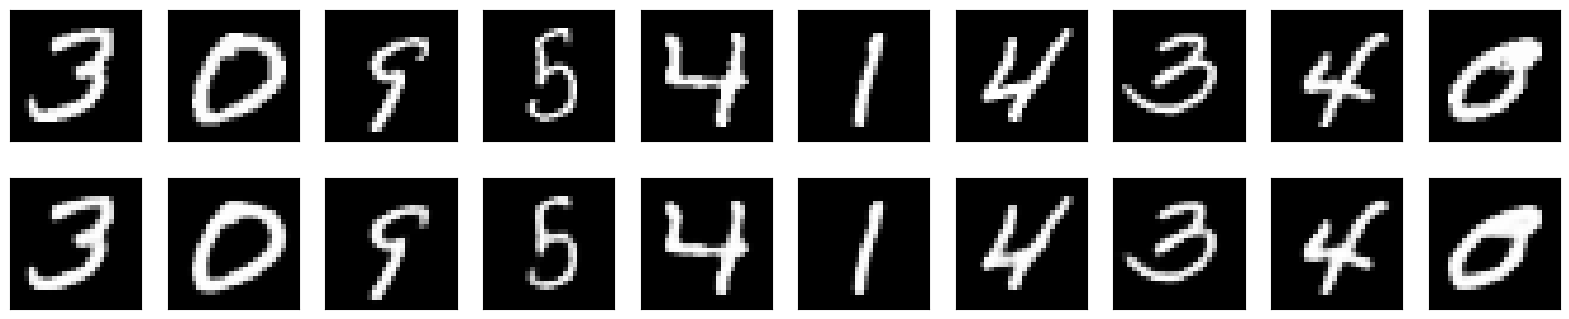

In [174]:


predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [175]:
autoencoder.fit(
    x=train_data,
    y=noisy_train_data,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, noisy_test_data),
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.5154 - val_loss: 0.4637
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.4631 - val_loss: 0.4624
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.4620 - val_loss: 0.4618
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.4615 - val_loss: 0.4614
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.4611 - val_loss: 0.4610


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


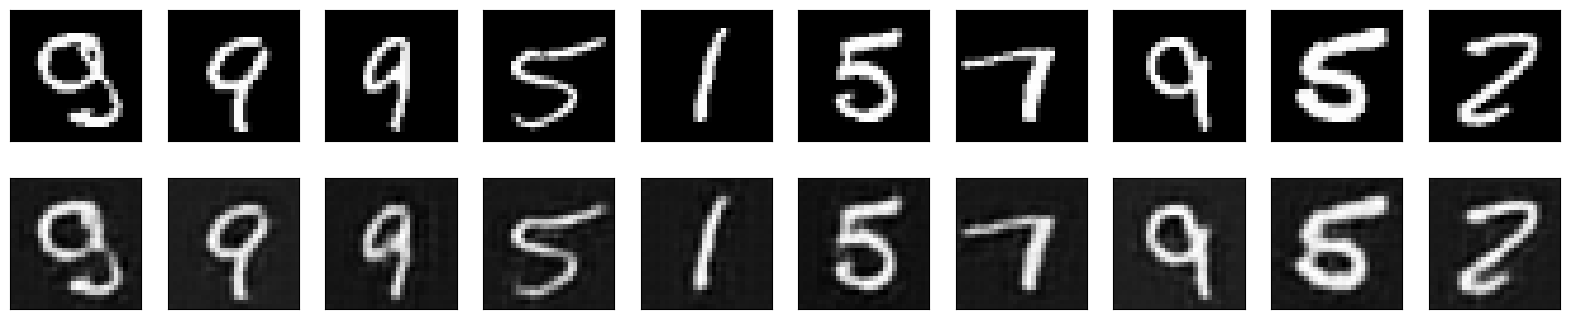

In [176]:
add_noise_predictions = autoencoder.predict(test_data)
display(test_data, add_noise_predictions)

In [118]:
import keras
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon
    
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [133]:
model.summary()

Model: "my_custom_model_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ ?                      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,400 (228.13 KB)

 Trainable params: 19,466 (76.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,934 (152.09 KB)

In [119]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3136)      │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 16)        │     50,192 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1007)

In [134]:
a = "!232143"
a[:3]

'!23'

## Playing around with text to image models

In [26]:
!pip3 install torch

  Using cached torch-2.2.2-cp311-none-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.2.2-cp311-none-macosx_11_0_arm64.whl (59.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 1.4 MB/s eta 0:00:00 0:00:010m
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [3]:


!pip3 install huggingface_hub

In [35]:
code_path = os.getenv("CODE_PATH")

In [40]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /Users/keonshikkim/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [41]:
!accelerate config

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/bin/accelerate", line 5, in <module>
    from accelerate.commands.accelerate_cli import main
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 21, in <module>
    from accelerate.commands.test import test_command_parser
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/accelerate/commands/test.py", line 19, in <module>
    from accelerate.test_utils import execute_subprocess_async, path_in_accelerate_package
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/accelerate/test_utils/__init__.py", line 14, in <module>
    from .testing import (
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/accelerate/test_utils/testing.py", line 76, in <module>
    torch_device, device_count, memory_allocated_func = g

In [42]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


'/Users/keonshikkim/.Trash/exploration/github.com/huggingface/diffusers/dog'

In [38]:
from diffusers import pipelines as pipelines_coreml

# Assuming your model is available as a Core ML model named "stable_diffusion.mlmodel"
model_id = code_path + "exploration/cat"

pipe = pipelines_coreml.StableDiffusionPipeline.from_pretrained(model_id)

prompt = "A <cat-toy> backpack"

image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.save("cat-backpack.png")



TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [1]:
from transformers import DreamBoothTrainer, TrainingArguments, AutoFeatureExtractor
from datasets import load_dataset
from huggingface_hub import notebook_login

notebook_login()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'DreamBoothTrainer' from 'transformers' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/__init__.py)

In [2]:
feature_extractor = AutoFeatureExtractor.from_pretrained("CompVis/stable-diffusion-v1-4")

NameError: name 'AutoFeatureExtractor' is not defined

In [32]:
# 2) 

In [ ]:
# 3)

In [ ]:

load_image()

#### VAE Training debugging

In [14]:
import math 

class AutoEncoderHiddenLayerDimensionIterator:
    def __init__(self, current_dim, input_dim, scaling_rate, input_to_waist_ratio):
        self.__current_dim = current_dim

        self.__input_dim = input_dim # what is the size of the input?
        self.__scaling_rate = scaling_rate
        self.__input_to_waist_ratio = input_to_waist_ratio

    def __iter__(self):
        return self
    
    def __next__(self):
        print("--> BEFORE", self.__current_dim)
        new_dim = math.ceil(self.__current_dim*self.__scaling_rate)
        if self.__input_dim/new_dim <= self.__input_to_waist_ratio:
            self.__current_dim = new_dim # update_current dim
            print("--> AFTER", self.__current_dim)
            return self.__current_dim
        else:
            raise StopIteration

In [15]:
hidden_dim = [d for d in AutoEncoderHiddenLayerDimensionIterator(256, 400, 0.75, 4)]
hidden_dim

--> BEFORE 256
--> AFTER 192
--> BEFORE 192
--> AFTER 144
--> BEFORE 144
--> AFTER 108
--> BEFORE 108


[192, 144, 108]

In [7]:
math.ceil(256*0.75)*0.75*0.75

108.0

In [9]:
400/108

3.7037037037037037